In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

## Binary Classification Model Tester

In [3]:
#%% Model Comparison Tool
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn import metrics
from sklearn import model_selection

class model_tester:
    def __init__(self, df, target):
        train_data, test_data = model_selection.train_test_split(df, test_size = 0.2) 
        self.X_train = train_data.drop(target, axis =1)
        self.y_train = train_data[target]
        self.X_test = test_data.drop(target, axis =1)
        self.y_test = test_data[target]
        self.models = {}
    
    def test_model(self, model, model_type):
        print(self.X_train.columns)
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred, average="macro")
        recall =  recall_score(self.y_test, y_pred, average="macro")
        f1 =  f1_score(self.y_test, y_pred, average="macro")
        
        y_prob = model.predict_proba(self.X_test)
        roc_auc = roc_auc_score(self.y_test, y_prob[:,1], average="macro")
        print(f'{model_type} model performance')
        print("Confusion Matrix:\n", confusion_matrix(self.y_test, y_pred))
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        print(f'ROC-AUC: {roc_auc}')
        metrics.RocCurveDisplay.from_predictions(self.y_test, y_prob[:,1], name = model_type)
        self.models[model_type] = {'model': model,'AUC': roc_auc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}
    
    def calc_scores(self, model_type):
        scores = []
        model = self.models[model_type]['model']
        #Note that everytime .fit() is called the parameters are reset so there's no influence from previously trained models
        ## Identifying the best predictor, see which variable when removed affects our model the most
        for i, var_name in enumerate(self.X_train.columns):    
            X_train_rem = self.X_train.drop(var_name, axis =1)
            X_test_rem = self.X_test.drop(var_name, axis =1)
            model.fit(X_train_rem, self.y_train)
            y_pred = model.predict(X_test_rem)
            accuracy = accuracy_score(self.y_test, y_pred)
            precision = precision_score(self.y_test, y_pred, average="macro")
            recall =  recall_score(self.y_test, y_pred, average="macro")
            f1 =  f1_score(self.y_test, y_pred, average="macro")
            y_prob = model.predict_proba(X_test_rem)
            roc_auc = roc_auc_score(self.y_test, y_prob[:,1], average="macro")
            print(f'{model_type} model without {var_name} trained. ({i+1}/{len(self.X_train.columns)})')
            scores.append({'name': var_name, 'AUC': roc_auc, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})
        self.scores = scores
        self.models[model_type]['scores'] = scores
    
    def find_best_predictors(self, model_type):
        print(f'===Lowest Performance Scores of each Metric of {model_type} model===')
        print(f'Lowest AUC: {sorted(self.scores, key = lambda x: x["AUC"])[0]["name"]}')
        print(f'Lowest Precision: {sorted(self.scores, key = lambda x: x["precision"])[0]["name"]}')
        print(f'Lowest Accuracy: {sorted(self.scores, key = lambda x: x["accuracy"])[0]["name"]}')
        print(f'Lowest Recall: {sorted(self.scores, key = lambda x: x["recall"])[0]["name"]}')
        print(f'Lowest F1: {sorted(self.scores, key = lambda x: x["f1"])[0]["name"]}')
        
    def predict(self, rows, model_type):
        model = self.models[model_type]['model']
        return model.predict_proba(rows)

## Data Processing

In [4]:
df = pd.read_csv('ALS 2017-2022 Donor Data.csv')
df.head()

,Donation ID,Donor ID,Received Date,Donation Amount,Campaign Id,Fund Description,Fund Name,Payment Type,First Gift Date,Last Gift Date,Gender,Age,Postal Code,City,Total Number of Donation,Total Amount of Donation,Retained
0,167648,1735748,2017-01-01,50.0,4053,Events:Walks,Events:Walks,Credit Card,2017-01-01,2017-01-01,Unknown or N/A,NaN,77494.0,Katy,3,130.0,1
1,168284,1736258,2017-01-01,500.0,7193,Unrestricted Giving:Memorials,Memorials,Other,2017-01-01,2017-01-01,Unknown or N/A,NaN,77493.0,Katy,1,500.0,0
2,168285,1736259,2017-01-01,1000.0,42,Individual Donor,Individual Donor,Other,2017-01-01,2017-01-01,Unknown or N/A,NaN,77018.0,Houston,1,1000.0,0
3,168286,1736260,2017-01-01,250.0,7193,Unrestricted Giving:Memorials,Memorials,Other,2017-01-01,2017-01-01,Unknown or N/A,NaN,77024.0,Houston,1,250.0,0
4,168343,1689213,2017-01-01,100.0,352,Individual Donor,Individual Donor,Other,2017-01-01,2017-01-01,Unknown or N/A,NaN,75048.0,Sachse,2,200.0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57716 entries, 0 to 57715
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Donation ID               57716 non-null  int64  
 1   Donor ID                  57716 non-null  int64  
 2   Received Date             57716 non-null  object 
 3   Donation Amount           57716 non-null  float64
 4   Campaign Id               57716 non-null  int64  
 5   Fund Description          57706 non-null  object 
 6   Fund Name                 57706 non-null  object 
 7   Payment Type              57706 non-null  object 
 8   First Gift Date           57716 non-null  object 
 9   Last Gift Date            57716 non-null  object 
 10  Gender                    57227 non-null  object 
 11  Age                       807 non-null    float64
 12  Postal Code               45230 non-null  float64
 13  City                      45409 non-null  object 
 14  Total 

### Convert Date Columns to DateTypes

In [6]:
for dateCol in ['Received Date', 'First Gift Date', 'Last Gift Date']:
    df[dateCol] = pd.to_datetime(df[dateCol])

### Introduce ZipCode Dataset

In [7]:
zipCodes = pd.read_csv('uszips.csv')

In [8]:
zipCodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33790 entries, 0 to 33789
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   zip               33790 non-null  int64  
 1   lat               33790 non-null  float64
 2   lng               33790 non-null  float64
 3   city              33790 non-null  object 
 4   state_id          33790 non-null  object 
 5   state_name        33790 non-null  object 
 6   zcta              33790 non-null  bool   
 7   parent_zcta       0 non-null      float64
 8   population        33773 non-null  float64
 9   density           33773 non-null  float64
 10  county_fips       33790 non-null  int64  
 11  county_name       33790 non-null  object 
 12  county_weights    33790 non-null  object 
 13  county_names_all  33790 non-null  object 
 14  county_fips_all   33790 non-null  object 
 15  imprecise         33790 non-null  bool   
 16  military          33790 non-null  bool  

### Merge and quantify Everything

In [9]:
quant_df = df.merge(zipCodes, 'inner', left_on = 'Postal Code', right_on = 'zip')

In [10]:
quant_df = quant_df[['Fund Description','Received Date', 'Donation Amount', 'Gender', 'Age', 'Retained', 'lat', 'lng','population', 'density']]

In [11]:
quant_df.head()

,Fund Description,Received Date,Donation Amount,Gender,Age,Retained,lat,lng,population,density
0,Events:Walks,2017-01-01,50.0,Unknown or N/A,NaN,1,29.74566,-95.82302,129165.0,1316.4
1,Unrestricted Giving:Memorials,2017-02-16,25.0,Unknown or N/A,NaN,0,29.74566,-95.82302,129165.0,1316.4
2,Unrestricted Giving:Memorials,2017-02-28,100.0,Male,NaN,1,29.74566,-95.82302,129165.0,1316.4
3,Unrestricted Giving:Memorials,2017-05-30,50.0,Female,NaN,0,29.74566,-95.82302,129165.0,1316.4
4,Events:Walks,2017-06-23,50.0,Unknown or N/A,NaN,0,29.74566,-95.82302,129165.0,1316.4


Map Fund Description column into binary variables

In [12]:
quant_df['Fund Description'].value_counts()

Events:Walks                                32050
Unrestricted Giving:Memorials                4194
Individual Donor                             2015
Events:Chapter Events (Non-Walk)             1599
Unrestricted Giving:Individual Donor         1182
Association Direct Mail                       990
AI - Comm Third Party                         874
Unrestricted Giving:Federated Donations       419
Events:Sponsorship                            334
Unrestricted Giving:In-Kind Donation          210
Restricted: Solicited                         138
Unrestricted Giving:DIY                        78
Unrestricted Giving:Matching Gifts             64
Restricted Giving:Solicited Restricted         41
AI - ADMHM                                     35
Unrestricted Giving:In-Kind Revenue            32
Restricted Giving:Unsolicited restricted       25
Restricted Giving:Grants                       21
Restricted Giving:Research                     19
Unrestricted Giving:Direct Mail                12


In [13]:
quant_df['Fund Description']

0                                Events:Walks
1               Unrestricted Giving:Memorials
2               Unrestricted Giving:Memorials
3               Unrestricted Giving:Memorials
4                                Events:Walks
                         ...                 
44374    Unrestricted Giving:Individual Donor
44375    Unrestricted Giving:Individual Donor
44376    Unrestricted Giving:Individual Donor
44377    Unrestricted Giving:Individual Donor
44378    Unrestricted Giving:Individual Donor
Name: Fund Description, Length: 44379, dtype: object

### Quick plot of each retained 

In [14]:
quant_df['Fund Description'].value_counts()

Events:Walks                                32050
Unrestricted Giving:Memorials                4194
Individual Donor                             2015
Events:Chapter Events (Non-Walk)             1599
Unrestricted Giving:Individual Donor         1182
Association Direct Mail                       990
AI - Comm Third Party                         874
Unrestricted Giving:Federated Donations       419
Events:Sponsorship                            334
Unrestricted Giving:In-Kind Donation          210
Restricted: Solicited                         138
Unrestricted Giving:DIY                        78
Unrestricted Giving:Matching Gifts             64
Restricted Giving:Solicited Restricted         41
AI - ADMHM                                     35
Unrestricted Giving:In-Kind Revenue            32
Restricted Giving:Unsolicited restricted       25
Restricted Giving:Grants                       21
Restricted Giving:Research                     19
Unrestricted Giving:Direct Mail                12


<Axes: >

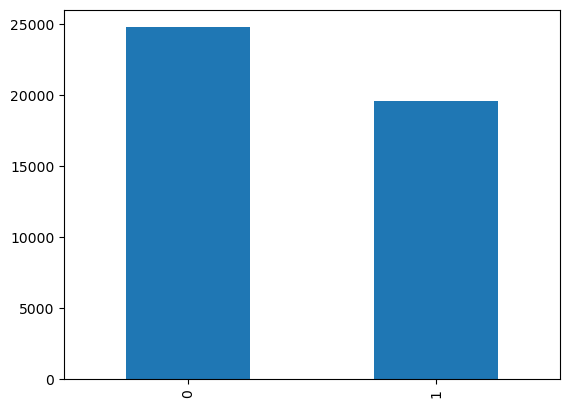

In [15]:
quant_df['Retained'].value_counts().plot.bar()

In [16]:
counts = quant_df['Fund Description'].value_counts()

In [17]:
retained_counts= quant_df[['Fund Description', 'Retained']].groupby(['Fund Description']).sum().sort_values(by = 'Retained', ascending = False)

In [18]:
pd.merge(counts, retained_counts, right_index=True, left_index = True)

,Fund Description,Retained
Events:Walks,32050,14546
Unrestricted Giving:Memorials,4194,844
Individual Donor,2015,1026
Events:Chapter Events (Non-Walk),1599,749
Unrestricted Giving:Individual Donor,1182,349
Association Direct Mail,990,880
AI - Comm Third Party,874,301
Unrestricted Giving:Federated Donations,419,301
Events:Sponsorship,334,243
Unrestricted Giving:In-Kind Donation,210,67


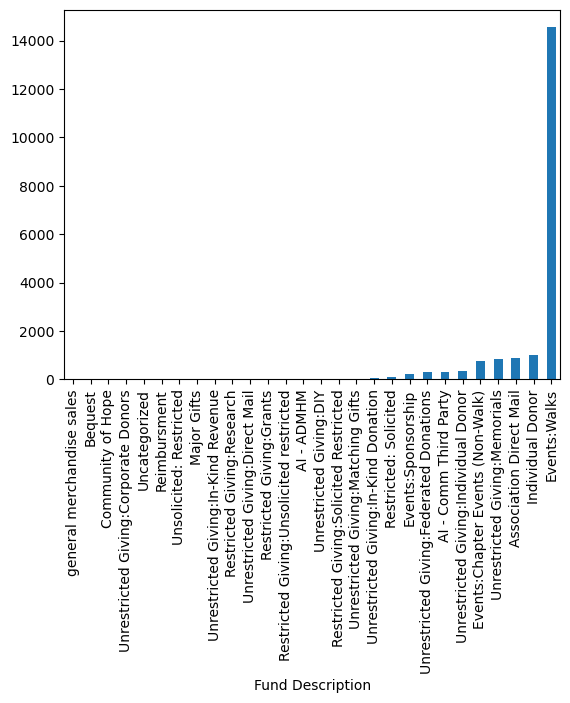

In [29]:
ax = quant_df.groupby('Fund Description')['Retained'].sum().sort_values().plot(kind='bar')

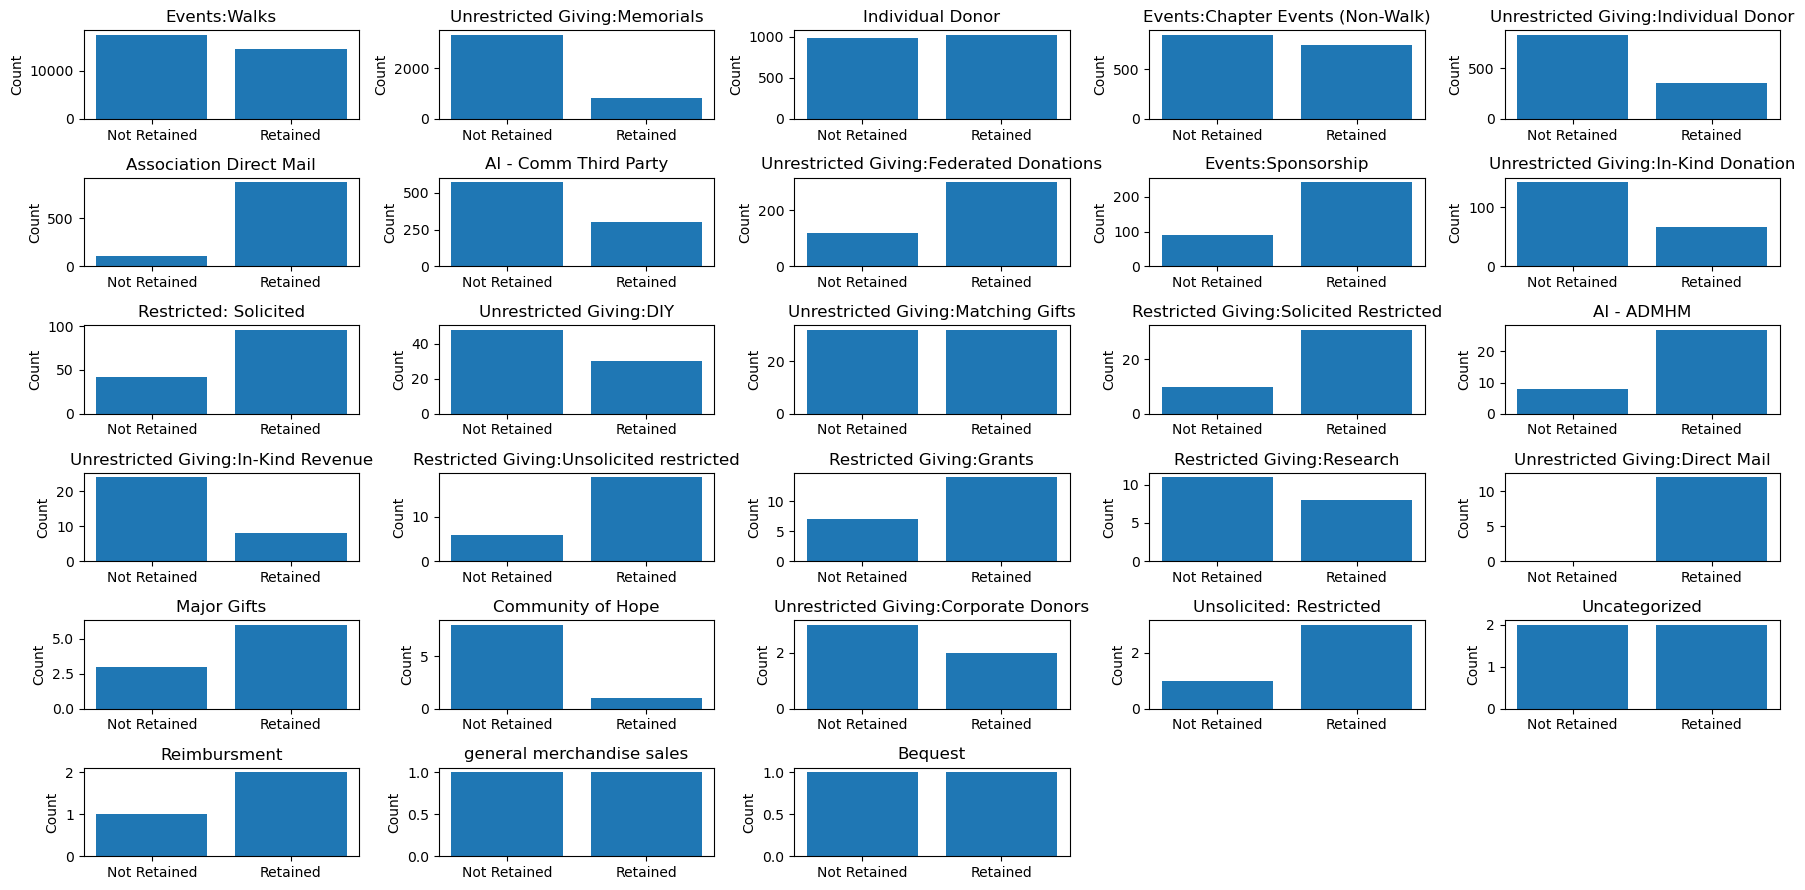

In [388]:
# Plotting Retained for each column
fig, axes = plt.subplots(6,5, figsize=(18,9))
fig.delaxes(axes[5][4])
fig.delaxes(axes[5][3])
for i, fund_type in enumerate(counts.index):
    ax = axes[i//5, i%5]
    retained = quant_df[quant_df['Fund Description'] == fund_type]['Retained'].value_counts()
    if len(retained.index)==1:
        retained.loc[0] = 0
    retained.sort_index(inplace = True)
    ax.bar(retained.index, retained.values)
    ax.set_xticks(retained.index)
    ax.set_xticklabels(['Not Retained', 'Retained'])
    ax.set_ylabel('Count')
    ax.set_title(f'{fund_type}')  
plt.tight_layout()
plt.show()

In [222]:
counts

Events:Walks                                32050
Unrestricted Giving:Memorials                4194
Individual Donor                             2015
Events:Chapter Events (Non-Walk)             1599
Unrestricted Giving:Individual Donor         1182
Association Direct Mail                       990
AI - Comm Third Party                         874
Unrestricted Giving:Federated Donations       419
Events:Sponsorship                            334
Unrestricted Giving:In-Kind Donation          210
Restricted: Solicited                         138
Unrestricted Giving:DIY                        78
Unrestricted Giving:Matching Gifts             64
Restricted Giving:Solicited Restricted         41
AI - ADMHM                                     35
Unrestricted Giving:In-Kind Revenue            32
Restricted Giving:Unsolicited restricted       25
Restricted Giving:Grants                       21
Restricted Giving:Research                     19
Unrestricted Giving:Direct Mail                12


In [223]:
dummies = pd.get_dummies(quant_df['Fund Description'])

In [224]:
quant_df['Walk'] = dummies['Events:Walks']
quant_df['Memorials'] = dummies['Unrestricted Giving:Memorials']
quant_df['Chapter'] = dummies['Events:Chapter Events (Non-Walk)']
quant_df['Individual Donor'] = dummies['Individual Donor'] + dummies['Unrestricted Giving:Individual Donor']
quant_df['Direct Mail'] = dummies['Association Direct Mail']+dummies['Unrestricted Giving:Direct Mail']
quant_df['Comm Third Party'] = dummies['AI - Comm Third Party']
quant_df['Federated Donations'] = dummies['Unrestricted Giving:Federated Donations']
quant_df['Sponsorship'] = dummies['Events:Sponsorship']
quant_df.drop('Fund Description', axis = 1, inplace = True)

In [225]:
quant_df.dropna(axis = 0, subset = 'Gender')
quant_df['Gender'].fillna('Unknown or N/A', inplace=True)
quant_df['Gender']= quant_df['Gender'].map({'Female': 1, 'Unknown or N/A': 0, 'Male': -1,  })

In [226]:
quant_df

,Received Date,Donation Amount,Gender,Age,Retained,lat,lng,population,density,Walk,Memorials,Chapter,Individual Donor,Direct Mail,Comm Third Party,Federated Donations,Sponsorship
0,2017-01-01,50.00,0,NaN,1,29.74566,-95.82302,129165.0,1316.4,1,0,0,0,0,0,0,0
1,2017-02-16,25.00,0,NaN,0,29.74566,-95.82302,129165.0,1316.4,0,1,0,0,0,0,0,0
2,2017-02-28,100.00,-1,NaN,1,29.74566,-95.82302,129165.0,1316.4,0,1,0,0,0,0,0,0
3,2017-05-30,50.00,1,NaN,0,29.74566,-95.82302,129165.0,1316.4,0,1,0,0,0,0,0,0
4,2017-06-23,50.00,0,NaN,0,29.74566,-95.82302,129165.0,1316.4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44374,2022-12-16,463.60,0,NaN,0,61.90744,-156.85203,12360.0,230.8,0,0,0,1,0,0,0,0
44375,2022-12-17,25.00,0,NaN,0,39.99813,-75.27388,15107.0,1671.3,0,0,0,1,0,0,0,0
44376,2022-12-19,51.69,0,NaN,0,34.07635,-89.89364,2130.0,8.0,0,0,0,1,0,0,0,0
44377,2022-12-21,103.18,0,NaN,0,42.94515,-85.61360,33651.0,1784.7,0,0,0,1,0,0,0,0


In [227]:
quant_df['Quarter'] = quant_df['Received Date'].dt.quarter
quant_df.drop(['Received Date'], axis = 1, inplace= True)

In [228]:
quant_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44379 entries, 0 to 44378
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Donation Amount      44379 non-null  float64
 1   Gender               44379 non-null  int64  
 2   Age                  802 non-null    float64
 3   Retained             44379 non-null  int64  
 4   lat                  44379 non-null  float64
 5   lng                  44379 non-null  float64
 6   population           44379 non-null  float64
 7   density              44379 non-null  float64
 8   Walk                 44379 non-null  uint8  
 9   Memorials            44379 non-null  uint8  
 10  Chapter              44379 non-null  uint8  
 11  Individual Donor     44379 non-null  uint8  
 12  Direct Mail          44379 non-null  uint8  
 13  Comm Third Party     44379 non-null  uint8  
 14  Federated Donations  44379 non-null  uint8  
 15  Sponsorship          44379 non-null 

Text(0.5, 1.0, 'Counts of Donor Retention')

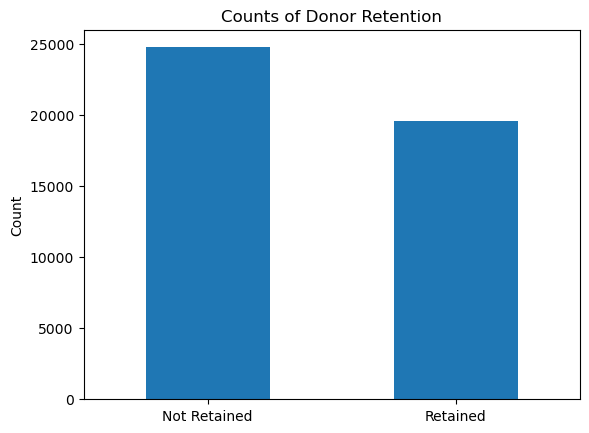

In [331]:
ax = quant_df['Retained'].value_counts().plot.bar()
ax.set_xticks((0,1), ("Not Retained", "Retained"), rotation = 0)
ax.set_ylabel('Count')
ax.set_title('Counts of Donor Retention')

In [230]:
quant_df['Gender'].value_counts()

 0    40702
 1     2293
-1     1384
Name: Gender, dtype: int64

# Models

### Initialize Tester

In [238]:
tester = model_tester(quant_df.drop('Age', axis=1), 'Retained')

### Logistic Regression

Index(['Donation Amount', 'Gender', 'lat', 'lng', 'population', 'density',
       'Walk', 'Memorials', 'Chapter', 'Individual Donor', 'Direct Mail',
       'Comm Third Party', 'Federated Donations', 'Sponsorship', 'Quarter'],
      dtype='object')
Logistic Regression model performance
Confusion Matrix:
 [[3280 1692]
 [2322 1582]]
Accuracy: 0.5477692654348806
Precision: 0.5343530770601389
Recall: 0.5324598489244688
F1 Score: 0.530590470862174
ROC-AUC: 0.5479591192233887


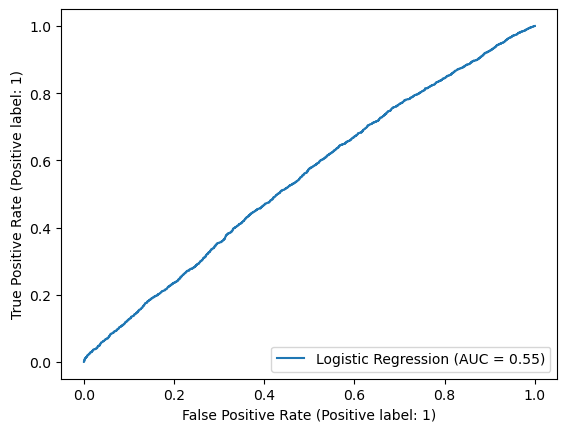

In [268]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(class_weight = 'balanced', max_iter = 3000)
tester.test_model(LR_model, "Logistic Regression")

In [240]:
rows = tester.X_test.head()
rows

,Donation Amount,Gender,lat,lng,population,density,Walk,Memorials,Chapter,Individual Donor,Direct Mail,Comm Third Party,Federated Donations,Sponsorship,Quarter
43936,25.00,0,41.08792,-73.54351,21604.0,1644.8,1,0,0,0,0,0,0,0,4
4194,100.00,1,32.97382,-96.74160,52420.0,1789.2,1,0,0,0,0,0,0,0,2
19667,51.43,0,31.33872,-94.83467,34663.0,83.4,0,1,0,0,0,0,0,0,1
43927,100.00,0,38.33528,-85.69689,47894.0,544.9,1,0,0,0,0,0,0,0,4
17028,50.00,0,34.01584,-118.49251,7482.0,3828.7,0,1,0,0,0,0,0,0,1


In [241]:
tester.predict(rows, "Logistic Regression")

array([[0.51429007, 0.48570993],
       [0.49499524, 0.50500476],
       [0.50356549, 0.49643451],
       [0.49220129, 0.50779871],
       [0.54157002, 0.45842998]])

In [242]:
tester.y_test.head()

43936    0
4194     0
19667    0
43927    0
17028    0
Name: Retained, dtype: int64

In [243]:
tester.calc_scores("Logistic Regression")
tester.find_best_predictors("Logistic Regression")

Logistic Regression model without Donation Amount trained. (1/15)
Logistic Regression model without Gender trained. (2/15)
Logistic Regression model without lat trained. (3/15)
Logistic Regression model without lng trained. (4/15)
Logistic Regression model without population trained. (5/15)
Logistic Regression model without density trained. (6/15)
Logistic Regression model without Walk trained. (7/15)
Logistic Regression model without Memorials trained. (8/15)
Logistic Regression model without Chapter trained. (9/15)
Logistic Regression model without Individual Donor trained. (10/15)
Logistic Regression model without Direct Mail trained. (11/15)
Logistic Regression model without Comm Third Party trained. (12/15)
Logistic Regression model without Federated Donations trained. (13/15)
Logistic Regression model without Sponsorship trained. (14/15)
Logistic Regression model without Quarter trained. (15/15)
===Lowest Performance Scores of each Metric of Logistic Regression model===
Lowest AU

### Support Vector Machine

Index(['Donation Amount', 'Gender', 'lat', 'lng', 'population', 'density',
       'Walk', 'Memorials', 'Chapter', 'Individual Donor', 'Direct Mail',
       'Comm Third Party', 'Federated Donations', 'Sponsorship', 'Quarter'],
      dtype='object')
SVM model performance
Confusion Matrix:
 [[4721  251]
 [3268  636]]
Accuracy: 0.6035376295628662
Precision: 0.6539806072131593
Recall: 0.5562135664640017
F1 Score: 0.4969954901069472
ROC-AUC: 0.6047448446958708


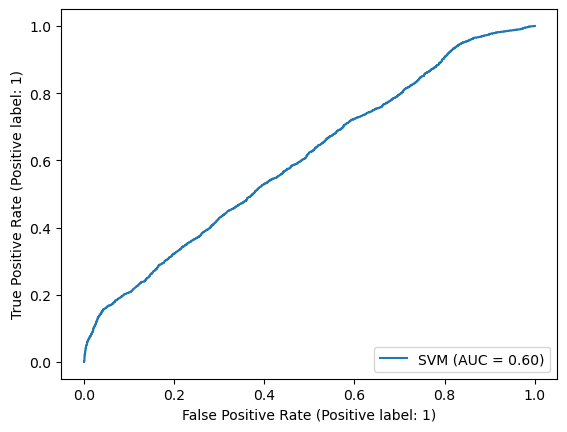

In [265]:
# Support Vector Machine Model
from sklearn.svm import LinearSVC 
from sklearn.calibration import CalibratedClassifierCV
#CalibratedClassifierCV allows us to use .predict_proba
SVM_model = CalibratedClassifierCV(LinearSVC(dual = False, class_weight = 'balanced'))
tester.test_model(SVM_model, 'SVM')

In [245]:
tester.calc_scores("SVM")
tester.find_best_predictors("SVM")

SVM model without Donation Amount trained. (1/15)
SVM model without Gender trained. (2/15)
SVM model without lat trained. (3/15)
SVM model without lng trained. (4/15)
SVM model without population trained. (5/15)
SVM model without density trained. (6/15)
SVM model without Walk trained. (7/15)
SVM model without Memorials trained. (8/15)
SVM model without Chapter trained. (9/15)
SVM model without Individual Donor trained. (10/15)
SVM model without Direct Mail trained. (11/15)
SVM model without Comm Third Party trained. (12/15)
SVM model without Federated Donations trained. (13/15)
SVM model without Sponsorship trained. (14/15)
SVM model without Quarter trained. (15/15)
===Lowest Performance Scores of each Metric of SVM model===
Lowest AUC: Direct Mail
Lowest Precision: Direct Mail
Lowest Accuracy: Gender
Lowest Recall: Gender
Lowest F1: Gender


### AdaBoost

Index(['Donation Amount', 'Gender', 'lat', 'lng', 'population', 'density',
       'Walk', 'Memorials', 'Chapter', 'Individual Donor', 'Direct Mail',
       'Comm Third Party', 'Federated Donations', 'Sponsorship', 'Quarter'],
      dtype='object')
Adaboost model performance
Confusion Matrix:
 [[3840 1132]
 [2095 1809]]
Accuracy: 0.636435331230284
Precision: 0.6310530864370818
Recall: 0.6178479608759875
F1 Score: 0.6163479763131858
ROC-AUC: 0.6826062012845706


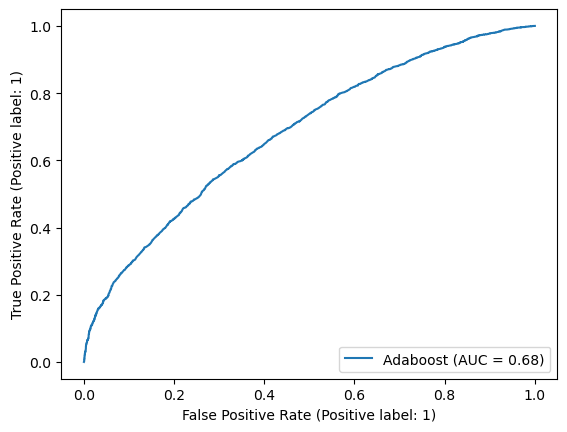

In [254]:
from sklearn.ensemble import AdaBoostClassifier
AB_model = AdaBoostClassifier()
tester.test_model(AB_model, "Adaboost")

In [248]:
tester.calc_scores("Adaboost")
tester.find_best_predictors("Adaboost")

Adaboost model without Donation Amount trained. (1/15)
Adaboost model without Gender trained. (2/15)
Adaboost model without lat trained. (3/15)
Adaboost model without lng trained. (4/15)
Adaboost model without population trained. (5/15)
Adaboost model without density trained. (6/15)
Adaboost model without Walk trained. (7/15)
Adaboost model without Memorials trained. (8/15)
Adaboost model without Chapter trained. (9/15)
Adaboost model without Individual Donor trained. (10/15)
Adaboost model without Direct Mail trained. (11/15)
Adaboost model without Comm Third Party trained. (12/15)
Adaboost model without Federated Donations trained. (13/15)
Adaboost model without Sponsorship trained. (14/15)
Adaboost model without Quarter trained. (15/15)
===Lowest Performance Scores of each Metric of Adaboost model===
Lowest AUC: Donation Amount
Lowest Precision: Gender
Lowest Accuracy: Donation Amount
Lowest Recall: Donation Amount
Lowest F1: Donation Amount


In [259]:
rows = tester.X_test.head(10)

In [261]:
rows

,Donation Amount,Gender,lat,lng,population,density,Walk,Memorials,Chapter,Individual Donor,Direct Mail,Comm Third Party,Federated Donations,Sponsorship,Quarter
43936,25.00,0,41.08792,-73.54351,21604.0,1644.8,1,0,0,0,0,0,0,0,4
4194,100.00,1,32.97382,-96.74160,52420.0,1789.2,1,0,0,0,0,0,0,0,2
19667,51.43,0,31.33872,-94.83467,34663.0,83.4,0,1,0,0,0,0,0,0,1
43927,100.00,0,38.33528,-85.69689,47894.0,544.9,1,0,0,0,0,0,0,0,4
17028,50.00,0,34.01584,-118.49251,7482.0,3828.7,0,1,0,0,0,0,0,0,1
2119,50.00,0,38.29705,-81.65463,14905.0,176.0,1,0,0,0,0,0,0,0,4
29264,500.00,-1,26.16650,-98.19082,79128.0,1175.0,1,0,0,0,0,0,0,0,4
28343,100.00,0,29.60929,-95.12417,18020.0,753.5,1,0,0,0,0,0,0,0,4
11376,100.00,0,30.17791,-95.50266,36080.0,1099.2,1,0,0,0,0,0,0,0,4
22927,30.00,0,33.02163,-96.74043,36221.0,1441.7,1,0,0,0,0,0,0,0,3


In [262]:
tester.predict(rows, 'Adaboost')

array([[0.50446948, 0.49553052],
       [0.49472055, 0.50527945],
       [0.50947188, 0.49052812],
       [0.50048048, 0.49951952],
       [0.51166713, 0.48833287],
       [0.50296484, 0.49703516],
       [0.49186665, 0.50813335],
       [0.50053329, 0.49946671],
       [0.49950659, 0.50049341],
       [0.50137452, 0.49862548]])

In [266]:
tester.predict(rows, 'SVM')

array([[0.62777182, 0.37222818],
       [0.47667878, 0.52332122],
       [0.79515314, 0.20484686],
       [0.58651256, 0.41348744],
       [0.79403338, 0.20596662],
       [0.60496473, 0.39503527],
       [0.55441065, 0.44558935],
       [0.54263958, 0.45736042],
       [0.53795086, 0.46204914],
       [0.55053571, 0.44946429]])

In [269]:
tester.predict(rows, 'Logistic Regression')

array([[0.51429007, 0.48570993],
       [0.49499524, 0.50500476],
       [0.50356549, 0.49643451],
       [0.49220129, 0.50779871],
       [0.54157002, 0.45842998],
       [0.5156064 , 0.4843936 ],
       [0.45956312, 0.54043688],
       [0.515877  , 0.484123  ],
       [0.50402202, 0.49597798],
       [0.50809749, 0.49190251]])

In [267]:
tester.y_test.head(10)

43936    0
4194     0
19667    0
43927    0
17028    0
2119     0
29264    1
28343    0
11376    1
22927    1
Name: Retained, dtype: int64

# Now Drop Missing Genders

In [118]:
quant_df['Gender'].value_counts()

 0    40702
 1     2293
-1     1384
Name: Gender, dtype: int64

In [119]:
quant_df_gender = quant_df[quant_df['Gender']!=0]

In [120]:
quant_df_gender

,Donation Amount,Gender,Age,Retained,lat,lng,population,density,Walk,Memorials,Chapter,Individual Donor,Direct Mail,Comm Third Party,Federated Donations,Sponsorship,Quarter
2,100.0,-1,NaN,1,29.74566,-95.82302,129165.0,1316.4,0,1,0,0,0,0,0,0,1
3,50.0,1,NaN,0,29.74566,-95.82302,129165.0,1316.4,0,1,0,0,0,0,0,0,2
15,100.0,1,70.0,0,29.74566,-95.82302,129165.0,1316.4,1,0,0,0,0,0,0,0,3
41,100.0,-1,NaN,1,29.74566,-95.82302,129165.0,1316.4,0,0,0,0,1,0,0,0,2
62,100.0,-1,60.0,0,29.74566,-95.82302,129165.0,1316.4,1,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44083,100.0,1,NaN,0,39.37215,-119.67611,36301.0,150.7,1,0,0,0,0,0,0,0,3
44171,1500.0,1,NaN,0,40.64180,-111.50332,8757.0,77.2,1,0,0,0,0,0,0,0,3
44263,400.0,-1,64.0,0,42.68138,-73.85099,30470.0,1127.6,1,0,0,0,0,0,0,0,3
44334,100.0,-1,NaN,0,37.67803,-122.13334,30262.0,3516.9,1,0,0,0,0,0,0,0,4


In [121]:
quant_df_gender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3677 entries, 2 to 44348
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Donation Amount      3677 non-null   float64
 1   Gender               3677 non-null   int64  
 2   Age                  597 non-null    float64
 3   Retained             3677 non-null   int64  
 4   lat                  3677 non-null   float64
 5   lng                  3677 non-null   float64
 6   population           3677 non-null   float64
 7   density              3677 non-null   float64
 8   Walk                 3677 non-null   uint8  
 9   Memorials            3677 non-null   uint8  
 10  Chapter              3677 non-null   uint8  
 11  Individual Donor     3677 non-null   uint8  
 12  Direct Mail          3677 non-null   uint8  
 13  Comm Third Party     3677 non-null   uint8  
 14  Federated Donations  3677 non-null   uint8  
 15  Sponsorship          3677 non-null   

### Logistic Regression

In [277]:
tester2 = model_tester(quant_df_gender.drop('Age', axis=1), 'Retained')

Index(['Donation Amount', 'Gender', 'lat', 'lng', 'population', 'density',
       'Walk', 'Memorials', 'Chapter', 'Individual Donor', 'Direct Mail',
       'Comm Third Party', 'Federated Donations', 'Sponsorship', 'Quarter'],
      dtype='object')
Logistic Regression model performance
Confusion Matrix:
 [[159  84]
 [260 233]]
Accuracy: 0.532608695652174
Precision: 0.5572453566023956
Recall: 0.5634688102571808
F1 Score: 0.5278355898698295
ROC-AUC: 0.5667993889765357


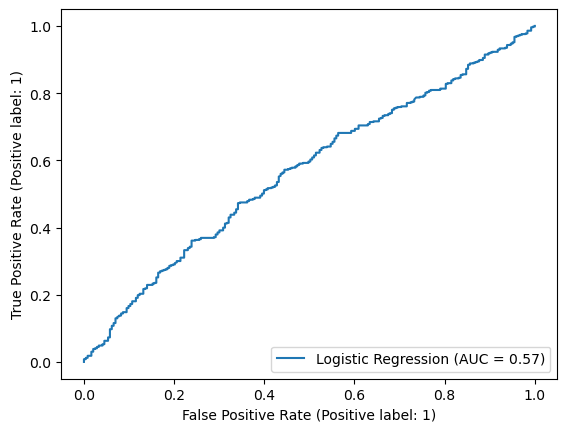

In [282]:
# Logistic Regression Model
LR_model = LogisticRegression(class_weight = 'balanced', max_iter = 3000)
tester2.test_model(LR_model, "Logistic Regression")

In [280]:
tester2.calc_scores("Logistic Regression")
tester2.find_best_predictors("Logistic Regression")

Logistic Regression model without Donation Amount trained. (1/15)
Logistic Regression model without Gender trained. (2/15)
Logistic Regression model without lat trained. (3/15)
Logistic Regression model without lng trained. (4/15)
Logistic Regression model without population trained. (5/15)
Logistic Regression model without density trained. (6/15)
Logistic Regression model without Walk trained. (7/15)
Logistic Regression model without Memorials trained. (8/15)
Logistic Regression model without Chapter trained. (9/15)
Logistic Regression model without Individual Donor trained. (10/15)
Logistic Regression model without Direct Mail trained. (11/15)
Logistic Regression model without Comm Third Party trained. (12/15)
Logistic Regression model without Federated Donations trained. (13/15)
Logistic Regression model without Sponsorship trained. (14/15)
Logistic Regression model without Quarter trained. (15/15)
===Lowest Performance Scores of each Metric of Logistic Regression model===
Lowest AU

### Support Vector Machine

Index(['Donation Amount', 'Gender', 'lat', 'lng', 'population', 'density',
       'Walk', 'Memorials', 'Chapter', 'Individual Donor', 'Direct Mail',
       'Comm Third Party', 'Federated Donations', 'Sponsorship', 'Quarter'],
      dtype='object')
SVM model performance
Confusion Matrix:
 [[ 69 174]
 [ 26 467]]
Accuracy: 0.7282608695652174
Precision: 0.7274324657196815
Recall: 0.6156061402849773
F1 Score: 0.6159585903175646
ROC-AUC: 0.6969590731141329


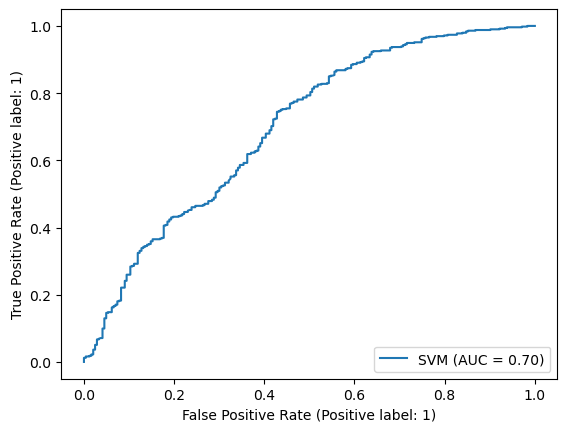

In [284]:
SVM_model = CalibratedClassifierCV(LinearSVC(dual = False, class_weight = 'balanced'))
tester2.test_model(SVM_model, "SVM")

In [283]:
tester2.calc_scores("SVM")
tester2.find_best_predictors("SVM")

SVM model without Donation Amount trained. (1/15)
SVM model without Gender trained. (2/15)
SVM model without lat trained. (3/15)
SVM model without lng trained. (4/15)
SVM model without population trained. (5/15)
SVM model without density trained. (6/15)
SVM model without Walk trained. (7/15)
SVM model without Memorials trained. (8/15)
SVM model without Chapter trained. (9/15)
SVM model without Individual Donor trained. (10/15)
SVM model without Direct Mail trained. (11/15)
SVM model without Comm Third Party trained. (12/15)
SVM model without Federated Donations trained. (13/15)
SVM model without Sponsorship trained. (14/15)
SVM model without Quarter trained. (15/15)
===Lowest Performance Scores of each Metric of SVM model===
Lowest AUC: Direct Mail
Lowest Precision: Memorials
Lowest Accuracy: Walk
Lowest Recall: Walk
Lowest F1: Walk


In [ ]:
row2

# Non Linear SVC

Index(['Donation Amount', 'Gender', 'lat', 'lng', 'population', 'density',
       'Walk', 'Memorials', 'Chapter', 'Individual Donor', 'Direct Mail',
       'Comm Third Party', 'Federated Donations', 'Sponsorship', 'Quarter'],
      dtype='object')
SVC model performance
Confusion Matrix:
 [[145  98]
 [242 251]]
Accuracy: 0.5380434782608695
Precision: 0.5469373551601845
Recall: 0.5529178039883471
F1 Score: 0.528258492629039
ROC-AUC: 0.557876109149492


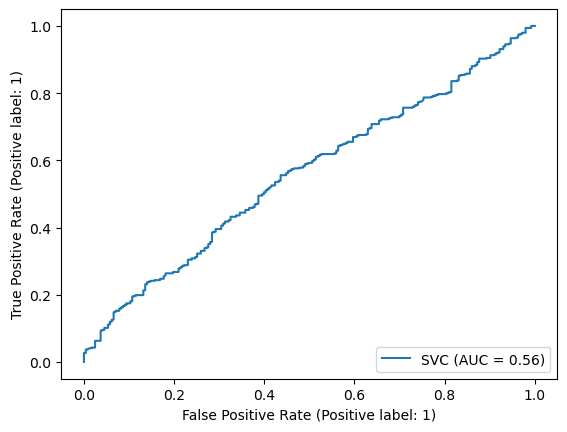

In [285]:
# Support Vector Machine Model
from sklearn.svm import SVC
#CalibratedClassifierCV allows us to use .predict_proba
SVC_model = SVC(class_weight = 'balanced', probability = True)
tester2.test_model(SVC_model, 'SVC')

In [128]:
tester2.calc_scores("SVC")
tester2.find_best_predictors("SVC")

SVC model without Donation Amount trained. (1/15)
SVC model without Gender trained. (2/15)
SVC model without lat trained. (3/15)
SVC model without lng trained. (4/15)
SVC model without population trained. (5/15)
SVC model without density trained. (6/15)
SVC model without Walk trained. (7/15)
SVC model without Memorials trained. (8/15)
SVC model without Chapter trained. (9/15)
SVC model without Individual Donor trained. (10/15)
SVC model without Direct Mail trained. (11/15)
SVC model without Comm Third Party trained. (12/15)
SVC model without Federated Donations trained. (13/15)
SVC model without Sponsorship trained. (14/15)
SVC model without Quarter trained. (15/15)
===Lowest Performance Scores of each Metric of SVC model===
Lowest AUC: Donation Amount
Lowest Precision: Donation Amount
Lowest Accuracy: Gender
Lowest Recall: Donation Amount
Lowest F1: Donation Amount


### AdaBoost

Index(['Donation Amount', 'Gender', 'lat', 'lng', 'population', 'density',
       'Walk', 'Memorials', 'Chapter', 'Individual Donor', 'Direct Mail',
       'Comm Third Party', 'Federated Donations', 'Sponsorship', 'Quarter'],
      dtype='object')
AdaBoost model performance
Confusion Matrix:
 [[102 141]
 [ 53 440]]
Accuracy: 0.7364130434782609
Precision: 0.7076897451557382
Recall: 0.6561240077129191
F1 Score: 0.6659648334783789
ROC-AUC: 0.729200577634204


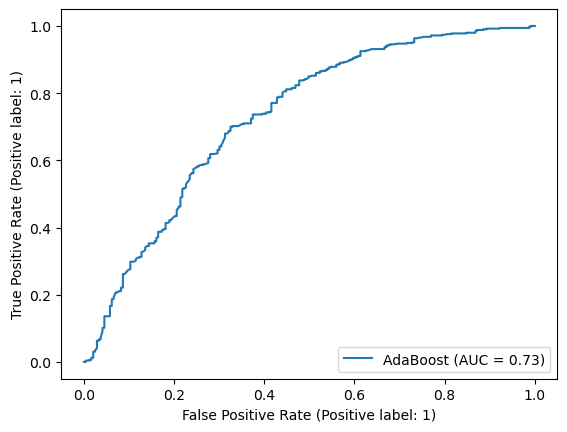

In [286]:
AB_model = AdaBoostClassifier()
tester2.test_model(AB_model, "AdaBoost")

In [130]:
tester2.calc_scores("AdaBoost")
tester2.find_best_predictors("AdaBoost")

AdaBoost model without Donation Amount trained. (1/15)
AdaBoost model without Gender trained. (2/15)
AdaBoost model without lat trained. (3/15)
AdaBoost model without lng trained. (4/15)
AdaBoost model without population trained. (5/15)
AdaBoost model without density trained. (6/15)
AdaBoost model without Walk trained. (7/15)
AdaBoost model without Memorials trained. (8/15)
AdaBoost model without Chapter trained. (9/15)
AdaBoost model without Individual Donor trained. (10/15)
AdaBoost model without Direct Mail trained. (11/15)
AdaBoost model without Comm Third Party trained. (12/15)
AdaBoost model without Federated Donations trained. (13/15)
AdaBoost model without Sponsorship trained. (14/15)
AdaBoost model without Quarter trained. (15/15)
===Lowest Performance Scores of each Metric of AdaBoost model===
Lowest AUC: Direct Mail
Lowest Precision: lng
Lowest Accuracy: Donation Amount
Lowest Recall: Donation Amount
Lowest F1: Donation Amount


In [321]:
rows2 = tester2.X_test.head(10)
actual = tester2.y_test.head(10)
rows2

,Donation Amount,Gender,lat,lng,population,density,Walk,Memorials,Chapter,Individual Donor,Direct Mail,Comm Third Party,Federated Donations,Sponsorship,Quarter
36202,52.5,1,32.88227,-97.34895,47569.0,1182.0,0,1,0,0,0,0,0,0,3
19057,10.0,1,30.55851,-97.91473,81311.0,252.4,0,0,0,0,1,0,0,0,3
30761,10.0,-1,32.77943,-97.51811,44125.0,395.3,1,0,0,0,0,0,0,0,4
1695,20.0,-1,29.72477,-95.36498,34197.0,2519.3,1,0,0,0,0,0,0,0,3
43004,30.0,1,32.26006,-99.52872,7673.0,11.6,0,1,0,0,0,0,0,0,3
958,100.0,1,29.57584,-95.13406,24761.0,1644.6,1,0,0,0,0,0,0,0,4
36557,100.0,1,33.57235,-96.17730,14726.0,40.4,0,0,0,0,0,1,0,0,4
22842,100.0,-1,30.05392,-95.15884,27274.0,1256.1,1,0,0,0,0,0,0,0,3
33060,50.0,1,31.85005,-106.45417,32148.0,1038.6,1,0,0,0,0,0,0,0,4
43449,500.0,-1,32.32614,-100.92807,7758.0,5.0,0,1,0,0,0,0,0,0,4


In [322]:
predicted = tester2.predict(rows2, "SVM")
prediction_prob = pd.DataFrame(data = predicted, index = rows2.index , columns = ["Predicted Not Retained Probability", "Predicted Retained Probability"])
prediction_prob.merge(actual, left_index = True, right_index = True)

,Predicted Not Retained Probability,Predicted Retained Probability,Retained
36202,0.676308,0.323692,0
19057,0.161712,0.838288,1
30761,0.243525,0.756475,0
1695,0.233041,0.766959,0
43004,0.721923,0.278077,0
958,0.245532,0.754468,1
36557,0.560112,0.439888,0
22842,0.237782,0.762218,0
33060,0.244651,0.755349,1
43449,0.727194,0.272806,0


# No Missing Age or Gender

In [52]:
tester3 = model_tester(quant_df.dropna(), 'Retained')

### Logistic Regression

Logistic Regression model performance
Confusion Matrix:
 [[26 27]
 [42 66]]
Accuracy: 0.5714285714285714
Precision: 0.5460151802656547
Recall: 0.55083857442348
F1 Score: 0.5432342420130751
ROC-AUC: 0.565863032844165


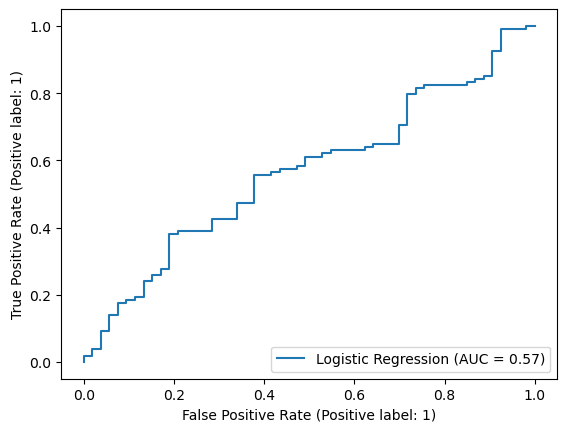

In [53]:
LR_model = LogisticRegression(class_weight = 'balanced', max_iter = 3000)
tester3.test_model(LR_model, "Logistic Regression")

In [54]:
tester2.calc_scores("Logistic Regression")
tester2.find_best_predictors("Logistic Regression")

Logistic Regression model without Donation Amount trained. (1/15)
Logistic Regression model without Gender trained. (2/15)
Logistic Regression model without lat trained. (3/15)
Logistic Regression model without lng trained. (4/15)
Logistic Regression model without population trained. (5/15)
Logistic Regression model without density trained. (6/15)
Logistic Regression model without Walk trained. (7/15)
Logistic Regression model without Memorials trained. (8/15)
Logistic Regression model without Chapter trained. (9/15)
Logistic Regression model without Individual Donor trained. (10/15)
Logistic Regression model without Direct Mail trained. (11/15)
Logistic Regression model without Comm Third Party trained. (12/15)
Logistic Regression model without Federated Donations trained. (13/15)
Logistic Regression model without Sponsorship trained. (14/15)
Logistic Regression model without Quarter trained. (15/15)
===Lowest Performance Scores of each Metric of Logistic Regression model===
Lowest AU

### SVM

SVM model performance
Confusion Matrix:
 [[  0  53]
 [  1 107]]
Accuracy: 0.6645962732919255
Precision: 0.334375
Recall: 0.49537037037037035
F1 Score: 0.39925373134328357
ROC-AUC: 0.6139063591893781


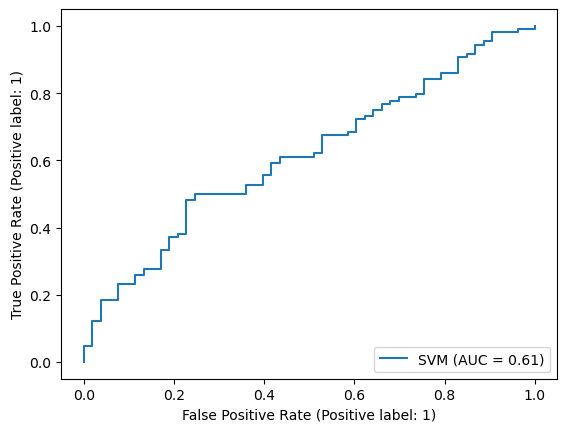

In [55]:
tester3.test_model(SVM_model, "SVM")

In [56]:
tester3.calc_scores("SVM")
tester3.find_best_predictors("SVM")

SVM model without Donation Amount trained. (1/16)
SVM model without Gender trained. (2/16)
SVM model without Age trained. (3/16)


/Users/frankliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankliu/opt/anaconda3/lib/python3.8/site-

SVM model without lat trained. (4/16)
SVM model without lng trained. (5/16)
SVM model without population trained. (6/16)
SVM model without density trained. (7/16)
SVM model without Walk trained. (8/16)
SVM model without Memorials trained. (9/16)


/Users/frankliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankliu/opt/anaconda3/lib/python3.8/site-

SVM model without Chapter trained. (10/16)
SVM model without Individual Donor trained. (11/16)
SVM model without Direct Mail trained. (12/16)
SVM model without Comm Third Party trained. (13/16)
SVM model without Federated Donations trained. (14/16)
SVM model without Sponsorship trained. (15/16)
SVM model without Quarter trained. (16/16)
===Lowest Performance Scores of each Metric of SVM model===
Lowest AUC: Direct Mail
Lowest Precision: Memorials
Lowest Accuracy: Memorials
Lowest Recall: Memorials
Lowest F1: Memorials


/Users/frankliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/frankliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
quant_df.drop('Age', axis = 1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44379 entries, 0 to 44378
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Donation Amount      44379 non-null  float64
 1   Gender               44379 non-null  int64  
 2   Retained             44379 non-null  int64  
 3   lat                  44379 non-null  float64
 4   lng                  44379 non-null  float64
 5   population           44379 non-null  float64
 6   density              44379 non-null  float64
 7   Walk                 44379 non-null  uint8  
 8   Memorials            44379 non-null  uint8  
 9   Chapter              44379 non-null  uint8  
 10  Individual Donor     44379 non-null  uint8  
 11  Direct Mail          44379 non-null  uint8  
 12  Comm Third Party     44379 non-null  uint8  
 13  Federated Donations  44379 non-null  uint8  
 14  Sponsorship          44379 non-null  uint8  
 15  Quarter              44379 non-null 